# **Capítulo 8: Visión por computador**

## Segmentación de animales en imágenes

Descargamos los datos del caso práctico

In [1]:
!wget -q http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget -q http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

Carga y preprocesado de datos

In [2]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input

# Rutas a los directorios de imágenes y máscaras
imgs_dir = 'images'
mascs_dir = 'annotations/trimaps/'

# Tamaño de las imágenes y máscaras
tam_img = (160, 160)

# Número de imágenes a cargar
num_imgs = 3000

def cargar_datos(imgs_dir, mascs_dir, tam_img, num_imgs=None):
    X = []
    Y = []
    img_list = sorted([i for i in os.listdir(imgs_dir)\
                       if i.endswith('.jpg') and not i.startswith('.')])

    if num_imgs is not None:
        img_list = img_list[:num_imgs]

    for inom in img_list:
        # Imagen
        img = img_to_array(load_img(os.path.join(imgs_dir, inom),\
                                    target_size=tam_img))
        # Máscara
        mnom = inom.replace('.jpg', '.png')
        masc = img_to_array(load_img(os.path.join(mascs_dir, mnom),\
                                     color_mode='grayscale',\
                                     target_size=tam_img))
        # Restamos 1 a todos los valores de la máscara
        masc -= 1

        X.append(img)
        Y.append(masc)

    X = preprocess_input(np.array(X))   # Normalizamos
    Y = np.array(Y, dtype='uint8')      # Convertimos a enteros

    return X, Y

X, Y = cargar_datos(imgs_dir, mascs_dir, tam_img, num_imgs)
print('¡Imágenes cargadas!')
print('Rango de valores de X: [{}, {}]'.format(X.min(), X.max()))

¡Imágenes cargadas!
Rango de valores de X: [-1.0, 1.0]


Visualización del aspecto de los datos

Tamaño de las imágenes: (160, 160, 3)
Tamaño de las máscaras: (160, 160, 1)


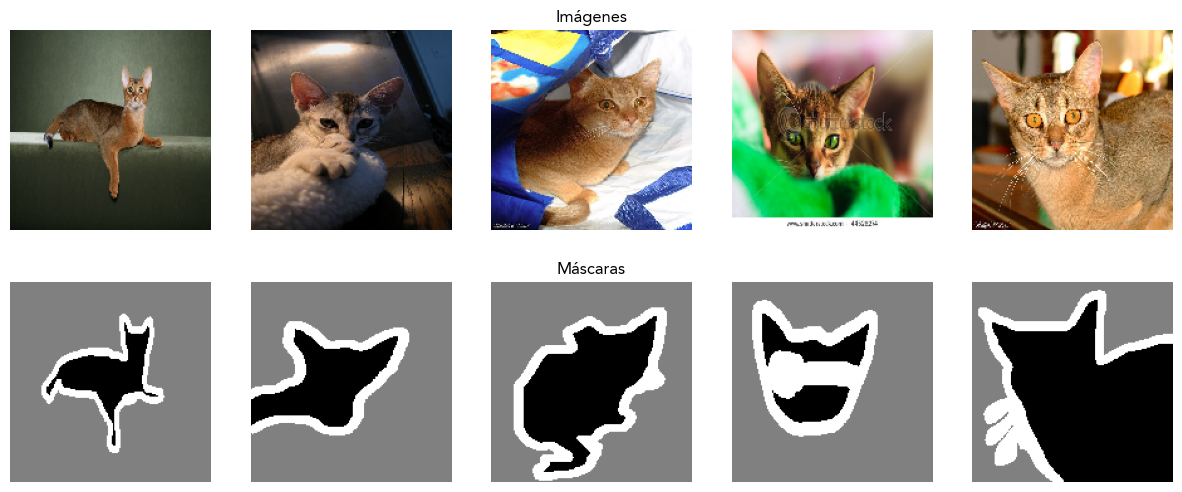

In [ ]:
import matplotlib.pyplot as plt

# Tamaño de los datos
print(f'Tamaño de las imágenes: {X.shape[1:]}')
print(f'Tamaño de las máscaras: {Y.shape[1:]}')

# Visualizamos las imágenes y las máscaras
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Trasladamos los valores de la imagen de [-1, 1]
    # a [0, 1] para su visualización
    axs[0, i].imshow((X[i] + 1) / 2)
    axs[0, i].axis('off')
    axs[1, i].imshow(Y[i], cmap='gray')
    axs[1, i].axis('off')
axs[0, 2].set_title('Imágenes')
axs[1, 2].set_title('Máscaras')
plt.show()

División del conjunto de datos en entrenamiento y test (80-20)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,\
                                                    test_size=0.2,\
                                                    random_state=42)
print('¡Particiones realizadas!')
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]}')
print(f'Tamaño del conjunto de test: {X_test.shape[0]}')

¡Particiones realizadas!
Tamaño del conjunto de entrenamiento: 2400
Tamaño del conjunto de test: 600


Implementación de la FCN a usar

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
    BatchNormalization, Dropout, Concatenate
from tensorflow.keras.applications import MobileNetV2

def crear_modelo(tam_entrada=(160, 160, 3), num_clases=3):
    # Cargamos el modelo preentrenado MobileNetV2 con ImageNet
    # y le indicamos que no incluya las capas de salida
    modelo_base = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=tam_entrada
    )

    # Codificador (base)
    # Obtenemos la salida de la capa 'block_6_expand_relu'
    # del modelo base
    # Tamaño salida: 20x20x192
    x = modelo_base.get_layer('block_6_expand_relu').output

    # Decodificador (personalizado)
    # Upsampling 1
    # Tamaño de salida: 40x40x512
    x = Conv2DTranspose(512, 3, 2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Upsampling 2 + residual
    # Tamaño de salida: 80x80x512
    x = Concatenate()(
        [x, modelo_base.get_layer('block_3_expand_relu').output])
    x = Conv2DTranspose(512, 3, 2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Upsampling 3 + residual
    # Tamaño de salida: 160x160x256
    x = Concatenate()(
        [x, modelo_base.get_layer('block_1_expand_relu').output])
    x = Conv2DTranspose(256, 3, 2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Capa de salida con convolución 1x1
    salida = Conv2D(num_clases, 1, padding='same',\
                    activation='softmax')(x)

    # Creamos el modelo final
    modelo = Model(inputs=modelo_base.input, outputs=salida)

    return modelo

modelo = crear_modelo()
print(modelo.summary())

9406464/9406464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)             

Fine-tuning: primero, entrenamos solo las capas añadidas

In [5]:
# Congelamos las capas del modelo base
for capa in modelo.layers:
    capa.trainable = False
    if capa.name == 'block_6_expand_relu':
        break

# Compilamos el modelo
modelo.compile(optimizer='adam',\
               loss='sparse_categorical_crossentropy',\
               metrics=['accuracy'])

# Entrenamos el modelo
historial1 = modelo.fit(X_train, Y_train,\
                        validation_data=(X_test, Y_test),\
                        epochs=10, batch_size=32, verbose=1)

Epoch 1/10
75/75 [==============================] - 130s 1s/step - loss: 0.8615 - accuracy: 0.7004 - val_loss: 0.8590 - val_accuracy: 0.6759
Epoch 2/10
75/75 [==============================] - 99s 1s/step - loss: 0.5967 - accuracy: 0.7629 - val_loss: 0.6198 - val_accuracy: 0.7530
Epoch 3/10
75/75 [==============================] - 99s 1s/step - loss: 0.5562 - accuracy: 0.7762 - val_loss: 0.5293 - val_accuracy: 0.7887
Epoch 4/10
75/75 [==============================] - 99s 1s/step - loss: 0.5406 - accuracy: 0.7816 - val_loss: 0.5148 - val_accuracy: 0.7941
Epoch 5/10
75/75 [==============================] - 99s 1s/step - loss: 0.5323 - accuracy: 0.7849 - val_loss: 0.5111 - val_accuracy: 0.7942
Epoch 6/10
75/75 [==============================] - 99s 1s/step - loss: 0.5285 - accuracy: 0.7858 - val_loss: 0.5131 - val_accuracy: 0.7915
Epoch 7/10
75/75 [==============================] - 99s 1s/step - loss: 0.5235 - accuracy: 0.7876 - val_loss: 0.5016 - val_accuracy: 0.7966
Epoch 8/10
75/75 [=

Fine-tuning: segundo, entrenamos el modelo al completo

In [6]:
from tensorflow.keras.optimizers import Adam

# Descongelamos las capas del modelo base
for capa in modelo.layers:
    capa.trainable = True
    if capa.name == 'block_6_expand_relu':
        break

# Compilamos el modelo usando un learning rate muy bajo
modelo.compile(optimizer=Adam(1e-5),\
               loss='sparse_categorical_crossentropy',\
               metrics=['accuracy'])

# Entrenamos el modelo
historial2 = modelo.fit(X_train, Y_train,\
                        validation_data=(X_test, Y_test),\
                        epochs=20, batch_size=32, verbose=1)

Epoch 1/20
75/75 [==============================] - 117s 1s/step - loss: 0.5151 - accuracy: 0.7910 - val_loss: 0.5130 - val_accuracy: 0.7902
Epoch 2/20
75/75 [==============================] - 103s 1s/step - loss: 0.5067 - accuracy: 0.7949 - val_loss: 0.5202 - val_accuracy: 0.7862
Epoch 3/20
75/75 [==============================] - 103s 1s/step - loss: 0.5021 - accuracy: 0.7971 - val_loss: 0.5146 - val_accuracy: 0.7889
Epoch 4/20
75/75 [==============================] - 103s 1s/step - loss: 0.4960 - accuracy: 0.8000 - val_loss: 0.5068 - val_accuracy: 0.7928
Epoch 5/20
75/75 [==============================] - 103s 1s/step - loss: 0.4917 - accuracy: 0.8021 - val_loss: 0.4975 - val_accuracy: 0.7972
Epoch 6/20
75/75 [==============================] - 103s 1s/step - loss: 0.4875 - accuracy: 0.8041 - val_loss: 0.4933 - val_accuracy: 0.7995
Epoch 7/20
75/75 [==============================] - 100s 1s/step - loss: 0.4831 - accuracy: 0.8061 - val_loss: 0.4834 - val_accuracy: 0.8043
Epoch 8/20
75

Visualización de las curvas de aprendizaje

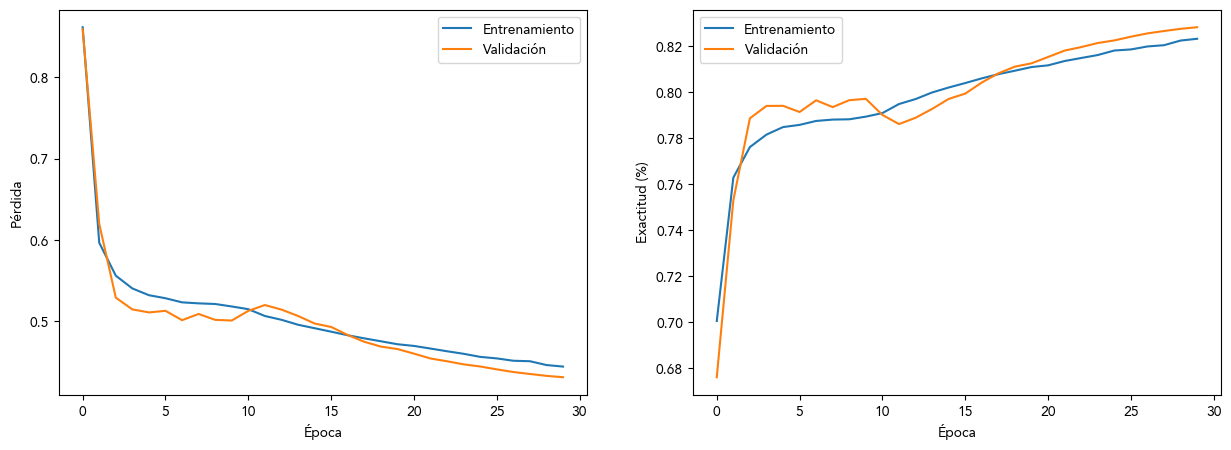

In [13]:
import matplotlib.pyplot as plt

# Concatemanos los historiales de entrenamiento
historial = historial1.history
for k in historial2.history:
    historial[k] += historial2.history[k]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Pérdida
axs[0].plot(historial['loss'], label='Entrenamiento')
axs[0].plot(historial['val_loss'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()
# Exactitud
axs[1].plot(historial['accuracy'], label='Entrenamiento')
axs[1].plot(historial['val_accuracy'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud (%)')
axs[1].legend()
plt.show()

Visualización de las predicciones del modelo

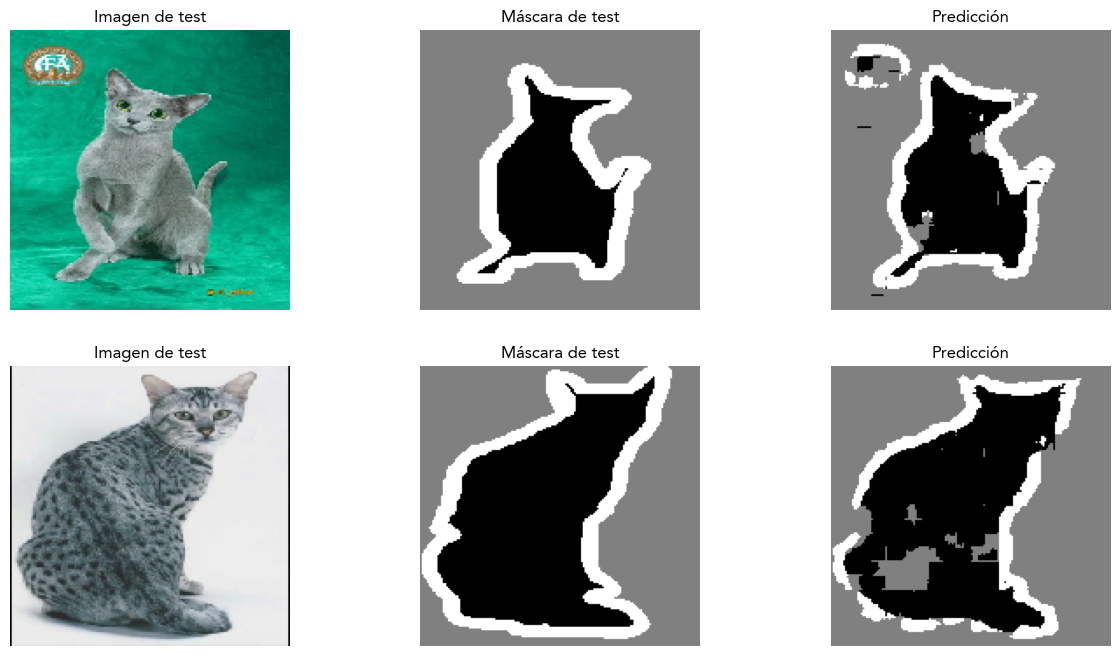

In [11]:
import matplotlib.pyplot as plt

# Obtenemos las predicciones
Y_pred = modelo.predict(X_test, verbose=0)
Y_pred = Y_pred.argmax(axis=-1)

# Visualizamos las predicciones
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i in range(2):
    ax[i, 0].set_title('Imagen de test')
    ax[i, 0].imshow((X_test[i] + 1) / 2)
    ax[i, 1].set_title('Máscara de test')
    ax[i, 1].imshow(Y_test[i], cmap='gray')
    ax[i, 2].set_title('Predicción')
    ax[i, 2].imshow(Y_pred[i], cmap='gray')
    # Hacemos los ejes invisibles
    for j in range(3):
        ax[i, j].set_axis_off()
plt.show()